In [ ]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)

import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Local imports
from utils.ncfdata import NCFData
from helpers.ncf_model import NCF
from helpers import download_ml1m_dataset
from helpers.ranking_metrics import hit, ndcg
from utils.load_all_data import load_all_data
from utils.ml_to_ncf import preprocess_ml1m_to_ncf_format


In [4]:
DATASET = 'ml-1m'

MODEL_NAME = 'NeuMF-end'
assert MODEL_NAME in ['MLP', 'GMF', 'NeuMF-end', 'NeuMF-pre'], \
    f"Model must be 'MLP', 'GMF', 'NeuMF-end', or 'NeuMF-pre', got '{MODEL_NAME}'"


DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Model saving directory
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

GMF_model_path = os.path.join(MODEL_PATH, 'GMF.pth')
MLP_model_path = os.path.join(MODEL_PATH, 'MLP.pth')
NeuMF_model_path = os.path.join(MODEL_PATH, 'NeuMF.pth')


# TRAINING HYPERPARAMETERS

LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
BATCH_SIZE = 256
EPOCHS = 20
TOP_K = 10
FACTOR_NUM = 32
NUM_LAYERS = 3
NUM_NG = 4
TEST_NUM_NG = 99
SAVE_MODEL = True

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [5]:
ratings_file = download_ml1m_dataset(DATA_DIR)

✓ Dataset already exists at /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat


In [6]:
train_rating_path, test_rating_path, test_negative_path, user_num, item_num, train_mat = preprocess_ml1m_to_ncf_format(ratings_file, data_dir=DATA_DIR)

✓ Training matrix created: 460225 interactions


In [7]:
train_data, test_data, user_num, item_num, train_mat = load_all_data(
    train_rating_path, test_negative_path
)

Loading training data from /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.train.rating...
✓ Loaded 460225 training pairs
  - Users: 6038
  - Items: 3533


In [8]:
train_dataset = NCFData(
    train_data,
    item_num,
    train_mat,
    num_ng=NUM_NG,  # From Step 2 configuration
    is_training=True
)

test_dataset = NCFData(
    test_data,
    item_num,
    train_mat,
    num_ng=0,  # No negative sampling for testing
    is_training=False
)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False 
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=TEST_NUM_NG + 1,  
    shuffle=False,  
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)


In [9]:
# Create the model
ncf_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=FACTOR_NUM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE,
    model_name=MODEL_NAME,
    GMF_model=None,
    MLP_model=None
)

# Move model to GPU if available
if torch.cuda.is_available():
    ncf_model = ncf_model.cuda()
    print("✓ Model moved to GPU")
else:
    print("✓ Model on CPU")

# Count parameters
total_params = sum(p.numel() for p in ncf_model.parameters())
trainable_params = sum(p.numel() for p in ncf_model.parameters() if p.requires_grad)

✓ Model on CPU


In [10]:
def evaluate_metrics(model, test_loader, top_k, device='cuda'):
    model.eval() 
    
    HR_list = [] 
    NDCG_list = []
    
    with torch.no_grad():  # Disable gradient computation (faster, saves memory)
        for user, item, label in test_loader:
            # Move data to device (GPU or CPU)
            if device == 'cuda' and torch.cuda.is_available():
                user = user.cuda()
                item = item.cuda()
            else:
                device = 'cpu'
            
            predictions = model(user, item)  
            _, indices = torch.topk(predictions, top_k)
            
            # Get the actual item IDs for top-K recommendations
            # torch.take extracts items at given indices
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            
            
            gt_item = item[0].item() 
            
            HR_list.append(hit(gt_item, recommends))
            NDCG_list.append(ndcg(gt_item, recommends))
    
    try:
        mean_HR = np.mean(HR_list)
        mean_NDCG = np.mean(NDCG_list)
    except Exception as e:
        print(f"Error calculating mean: {e}")
        mean_HR = 0
        mean_NDCG = 0
    
    return mean_HR, mean_NDCG

In [12]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(ncf_model.parameters(), lr=LEARNING_RATE)
total_params = sum(p.numel() for p in ncf_model.parameters() if p.requires_grad)

In [13]:
# Track best performance
best_hr = 0.0
best_ndcg = 0.0
best_epoch = 0
training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': [],
    'time': []
}

# Training loop
for epoch in range(EPOCHS):
    ncf_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    epoch_loss = 0.0
    num_batches = 0
    
    # Iterate through training batches
    for batch_idx, (user, item, label) in enumerate(train_loader):
        # Move data to device (GPU or CPU)
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        optimizer.zero_grad()
        
        
        prediction = ncf_model(user, item) 
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
        if (batch_idx + 1) % 100 == 0:
            avg_loss = epoch_loss / num_batches
    
    # Calculate average loss for this epoch
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    

    ncf_model.eval()
    
    # Evaluate on test set
    print("  Evaluating on test set...")
    HR, NDCG = evaluate_metrics(ncf_model, test_loader, TOP_K, device)
    
    # Calculate elapsed time
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    training_history['epoch'].append(epoch + 1)
    training_history['loss'].append(avg_loss)
    training_history['hr'].append(HR)
    training_history['ndcg'].append(NDCG)
    training_history['time'].append(elapsed_time)
    
    # Print epoch results
    print(f"  Time: {time_str}")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  HR@{TOP_K}: {HR:.4f}")
    print(f"  NDCG@{TOP_K}: {NDCG:.4f}")
    
    # Check if this is the best model so far
    if HR > best_hr:
        best_hr = HR
        best_ndcg = NDCG
        best_epoch = epoch + 1
        
        print(f"  ✓ New best model! (HR@{TOP_K}: {HR:.4f})")
        
        # Save model if enabled
        if SAVE_MODEL:
            if not os.path.exists(MODEL_PATH):
                os.makedirs(MODEL_PATH)
            
            model_filename = os.path.join(MODEL_PATH, f'{MODEL_NAME}.pth')
            torch.save(ncf_model, model_filename)
            print(f"  ✓ Model saved to {model_filename}")
    else:
        print(f"  (Best: HR@{TOP_K}: {best_hr:.4f} at epoch {best_epoch})")
    
    print("-" * 70)

# Store the NeuMF-end model for later comparison
ncf_model_neumf_end = ncf_model
best_hr_neumf_end = best_hr
best_ndcg_neumf_end = best_ndcg


✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
  Evaluating on test set...
  Time: 00:00:48
  Loss: 0.3265
  HR@10: 0.7023
  NDCG@10: 0.4244
  ✓ New best model! (HR@10: 0.7023)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/NeuMF-end.pth
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
  Evaluating on test set...
  Time: 00:00:44
  Loss: 0.2734
  HR@10: 0.7341
  NDCG@10: 0.4511
  ✓ New best model! (HR@10: 0.7341)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/NeuMF-end.pth
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
  Evaluating on test set...
  Time: 00:00:43
  Loss: 0.2518
  HR@10: 0.7392
  NDCG@10: 0.4559
  ✓ New best model! (HR@10: 0.7392)
  ✓ Model save

---

## Step 7.5: Train Models Separately (GMF, MLP, NeuMF-pre)

In this step, we'll train each model architecture separately:
1. **Train GMF model** - Generalized Matrix Factorization only
2. **Train MLP model** - Multi-Layer Perceptron only  
3. **Train NeuMF-pre** - Neural Matrix Factorization using pre-trained GMF and MLP weights

This approach (NeuMF-pre) typically gives the best performance as it leverages pre-trained components.


In [14]:
# Create GMF model
gmf_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=FACTOR_NUM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE,
    model_name='GMF',
    GMF_model=None,
    MLP_model=None
)

if torch.cuda.is_available():
    gmf_model = gmf_model.cuda()

# Setup optimizer and loss
gmf_optimizer = optim.Adam(gmf_model.parameters(), lr=LEARNING_RATE)
gmf_loss_function = nn.BCEWithLogitsLoss()

In [15]:
# Store trained models
trained_models = {}

# Training loop for GMF
print(f"Training GMF for {EPOCHS} epochs...")
best_hr_gmf = 0.0
best_ndcg_gmf = 0.0
best_epoch_gmf = 0
gmf_training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': []
}

for epoch in range(EPOCHS):
    gmf_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (user, item, label) in enumerate(train_loader):
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        gmf_optimizer.zero_grad()
        prediction = gmf_model(user, item)
        loss = gmf_loss_function(prediction, label)
        loss.backward()
        gmf_optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # Evaluate
    gmf_model.eval()
    HR, NDCG = evaluate_metrics(gmf_model, test_loader, TOP_K, device)
    
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    gmf_training_history['epoch'].append(epoch + 1)
    gmf_training_history['loss'].append(avg_loss)
    gmf_training_history['hr'].append(HR)
    gmf_training_history['ndcg'].append(NDCG)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Time: {time_str} - Loss: {avg_loss:.4f} - HR@{TOP_K}: {HR:.4f} - NDCG@{TOP_K}: {NDCG:.4f}")
    
    if HR > best_hr_gmf:
        best_hr_gmf = HR
        best_ndcg_gmf = NDCG
        best_epoch_gmf = epoch + 1
        if SAVE_MODEL:
            torch.save(gmf_model, GMF_model_path)
            print(f"  ✓ Saved best GMF model (HR@{TOP_K}: {HR:.4f})")

print(f"\n✓ GMF Training Complete!")
print(f"  Best epoch: {best_epoch_gmf}")
print(f"  Best HR@{TOP_K}: {best_hr_gmf:.4f}")
print(f"  Best NDCG@{TOP_K}: {best_ndcg_gmf:.4f}")

trained_models['GMF'] = {
    'model': gmf_model,
    'hr': best_hr_gmf,
    'ndcg': best_ndcg_gmf,
    'epoch': best_epoch_gmf
}


Training GMF for 20 epochs...
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 1/20 - Time: 00:00:23 - Loss: 0.3577 - HR@10: 0.6547 - NDCG@10: 0.3865
  ✓ Saved best GMF model (HR@10: 0.6547)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 2/20 - Time: 00:00:21 - Loss: 0.2969 - HR@10: 0.7026 - NDCG@10: 0.4229
  ✓ Saved best GMF model (HR@10: 0.7026)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 3/20 - Time: 00:00:22 - Loss: 0.2781 - HR@10: 0.7239 - NDCG@10: 0.4419
  ✓ Saved best GMF model (HR@10: 0.7239)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 4/20 - Time: 00:00:21 - Loss: 0.2659 - HR@10: 0.7367 - NDCG@10: 0.4540
  ✓ Saved best GMF model (HR@10: 0.7367)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 5/20 - Time: 00:00:21 - Loss: 0.2558 - HR@10: 0.7452

In [16]:
# Create MLP model
mlp_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=FACTOR_NUM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE,
    model_name='MLP',
    GMF_model=None,
    MLP_model=None
)

if torch.cuda.is_available():
    mlp_model = mlp_model.cuda()

# Setup optimizer and loss
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
mlp_loss_function = nn.BCEWithLogitsLoss()


In [17]:
# Training loop for MLP
best_hr_mlp = 0.0
best_ndcg_mlp = 0.0
best_epoch_mlp = 0
mlp_training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': []
}

for epoch in range(EPOCHS):
    mlp_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (user, item, label) in enumerate(train_loader):
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        mlp_optimizer.zero_grad()
        prediction = mlp_model(user, item)
        loss = mlp_loss_function(prediction, label)
        loss.backward()
        mlp_optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # Evaluate
    mlp_model.eval()
    HR, NDCG = evaluate_metrics(mlp_model, test_loader, TOP_K, device)
    
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    mlp_training_history['epoch'].append(epoch + 1)
    mlp_training_history['loss'].append(avg_loss)
    mlp_training_history['hr'].append(HR)
    mlp_training_history['ndcg'].append(NDCG)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Time: {time_str} - Loss: {avg_loss:.4f} - HR@{TOP_K}: {HR:.4f} - NDCG@{TOP_K}: {NDCG:.4f}")
    
    if HR > best_hr_mlp:
        best_hr_mlp = HR
        best_ndcg_mlp = NDCG
        best_epoch_mlp = epoch + 1
        if SAVE_MODEL:
            torch.save(mlp_model, MLP_model_path)
            print(f"  ✓ Saved best MLP model (HR@{TOP_K}: {HR:.4f})")

print(f"\n✓ MLP Training Complete!")
print(f"  Best epoch: {best_epoch_mlp}")
print(f"  Best HR@{TOP_K}: {best_hr_mlp:.4f}")
print(f"  Best NDCG@{TOP_K}: {best_ndcg_mlp:.4f}")

trained_models['MLP'] = {
    'model': mlp_model,
    'hr': best_hr_mlp,
    'ndcg': best_ndcg_mlp,
    'epoch': best_epoch_mlp
}


✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 1/20 - Time: 00:00:40 - Loss: 0.3504 - HR@10: 0.5700 - NDCG@10: 0.3263
  ✓ Saved best MLP model (HR@10: 0.5700)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 2/20 - Time: 00:00:38 - Loss: 0.3233 - HR@10: 0.6436 - NDCG@10: 0.3771
  ✓ Saved best MLP model (HR@10: 0.6436)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 3/20 - Time: 00:00:39 - Loss: 0.3063 - HR@10: 0.6697 - NDCG@10: 0.3952
  ✓ Saved best MLP model (HR@10: 0.6697)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 4/20 - Time: 00:00:38 - Loss: 0.2939 - HR@10: 0.6961 - NDCG@10: 0.4168
  ✓ Saved best MLP model (HR@10: 0.6961)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 5/20 - Time: 00:00:43 - Loss: 0.2837 - HR@10: 0.7090 - NDCG@10: 0.4286
  ✓ Saved b

In [18]:
# Create NeuMF-pre model using pre-trained GMF and MLP
neumf_pre_model = NCF(
    user_num=user_num,
    item_num=item_num,
    factor_num=FACTOR_NUM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT_RATE,
    model_name='NeuMF-pre',
    GMF_model=gmf_model,
    MLP_model=mlp_model
)

if torch.cuda.is_available():
    neumf_pre_model = neumf_pre_model.cuda()

# Setup optimizer (SGD is typically used for NeuMF-pre)
neumf_pre_optimizer = optim.SGD(neumf_pre_model.parameters(), lr=LEARNING_RATE)
neumf_pre_loss_function = nn.BCEWithLogitsLoss()

In [19]:
best_hr_neumf_pre = 0.0
best_ndcg_neumf_pre = 0.0
best_epoch_neumf_pre = 0
neumf_pre_training_history = {
    'epoch': [],
    'loss': [],
    'hr': [],
    'ndcg': []
}

for epoch in range(EPOCHS):
    neumf_pre_model.train()
    epoch_start_time = time.time()
    train_dataset.ng_sample()
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (user, item, label) in enumerate(train_loader):
        if device == 'cuda' and torch.cuda.is_available():
            user = user.cuda()
            item = item.cuda()
            label = label.float().cuda()
        else:
            user = user
            item = item
            label = label.float()
        
        neumf_pre_optimizer.zero_grad()
        prediction = neumf_pre_model(user, item)
        loss = neumf_pre_loss_function(prediction, label)
        loss.backward()
        neumf_pre_optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    
    # Evaluate
    neumf_pre_model.eval()
    HR, NDCG = evaluate_metrics(neumf_pre_model, test_loader, TOP_K, device)
    
    elapsed_time = time.time() - epoch_start_time
    time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
    # Store history
    neumf_pre_training_history['epoch'].append(epoch + 1)
    neumf_pre_training_history['loss'].append(avg_loss)
    neumf_pre_training_history['hr'].append(HR)
    neumf_pre_training_history['ndcg'].append(NDCG)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Time: {time_str} - Loss: {avg_loss:.4f} - HR@{TOP_K}: {HR:.4f} - NDCG@{TOP_K}: {NDCG:.4f}")
    
    if HR > best_hr_neumf_pre:
        best_hr_neumf_pre = HR
        best_ndcg_neumf_pre = NDCG
        best_epoch_neumf_pre = epoch + 1
        if SAVE_MODEL:
            torch.save(neumf_pre_model, NeuMF_model_path)
            print(f"  ✓ Saved best NeuMF-pre model (HR@{TOP_K}: {HR:.4f})")

print(f"\n✓ NeuMF-pre Training Complete!")
print(f"  Best epoch: {best_epoch_neumf_pre}")
print(f"  Best HR@{TOP_K}: {best_hr_neumf_pre:.4f}")
print(f"  Best NDCG@{TOP_K}: {best_ndcg_neumf_pre:.4f}")

trained_models['NeuMF-pre'] = {
    'model': neumf_pre_model,
    'hr': best_hr_neumf_pre,
    'ndcg': best_ndcg_neumf_pre,
    'epoch': best_epoch_neumf_pre
}

✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 1/20 - Time: 00:00:35 - Loss: 0.1998 - HR@10: 0.7695 - NDCG@10: 0.4858
  ✓ Saved best NeuMF-pre model (HR@10: 0.7695)
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 2/20 - Time: 00:00:34 - Loss: 0.1996 - HR@10: 0.7692 - NDCG@10: 0.4852
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 3/20 - Time: 00:00:32 - Loss: 0.1989 - HR@10: 0.7689 - NDCG@10: 0.4850
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 4/20 - Time: 00:00:32 - Loss: 0.1985 - HR@10: 0.7685 - NDCG@10: 0.4846
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 5/20 - Time: 00:00:34 - Loss: 0.1982 - HR@10: 0.7682 - NDCG@10: 0.4845
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
Epoch 6/20 - Time: 00:00:36 - Loss: 0.19

In [20]:

print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Model':<15} {'HR@{TOP_K}':<12} {'NDCG@{TOP_K}':<12} {'Best Epoch':<12}")
print("-" * 70)
print(f"{'GMF':<15} {best_hr_gmf:<12.4f} {best_ndcg_gmf:<12.4f} {best_epoch_gmf:<12}")
print(f"{'MLP':<15} {best_hr_mlp:<12.4f} {best_ndcg_mlp:<12.4f} {best_epoch_mlp:<12}")
print(f"{'NeuMF-end':<15} {best_hr_neumf_end:<12.4f} {best_ndcg_neumf_end:<12.4f} {best_epoch:<12}")
print(f"{'NeuMF-pre':<15} {best_hr_neumf_pre:<12.4f} {best_ndcg_neumf_pre:<12.4f} {best_epoch_neumf_pre:<12}")
print("=" * 70)

# Find best model
all_results = [
    ('GMF', best_hr_gmf, best_ndcg_gmf),
    ('MLP', best_hr_mlp, best_ndcg_mlp),
    ('NeuMF-end', best_hr_neumf_end, best_ndcg_neumf_end),
    ('NeuMF-pre', best_hr_neumf_pre, best_ndcg_neumf_pre)
]
best_model_name, best_hr_overall, best_ndcg_overall = max(all_results, key=lambda x: x[1])

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   HR@{TOP_K}: {best_hr_overall:.4f}")
print(f"   NDCG@{TOP_K}: {best_ndcg_overall:.4f}")

# Set the best model as the main model for recommendations
if best_model_name == 'GMF':
    ncf_model = gmf_model
elif best_model_name == 'MLP':
    ncf_model = mlp_model
elif best_model_name == 'NeuMF-pre':
    ncf_model = neumf_pre_model
else:
    ncf_model = ncf_model_neumf_end

print(f"\n✓ Using {best_model_name} model for recommendations")
print("=" * 70)



MODEL COMPARISON SUMMARY
Model           HR@{TOP_K}   NDCG@{TOP_K} Best Epoch  
----------------------------------------------------------------------
GMF             0.7499       0.4653       7           
MLP             0.7541       0.4703       20          
NeuMF-end       0.7402       0.4582       5           
NeuMF-pre       0.7695       0.4858       1           

🏆 Best Model: NeuMF-pre
   HR@10: 0.7695
   NDCG@10: 0.4858

✓ Using NeuMF-pre model for recommendations


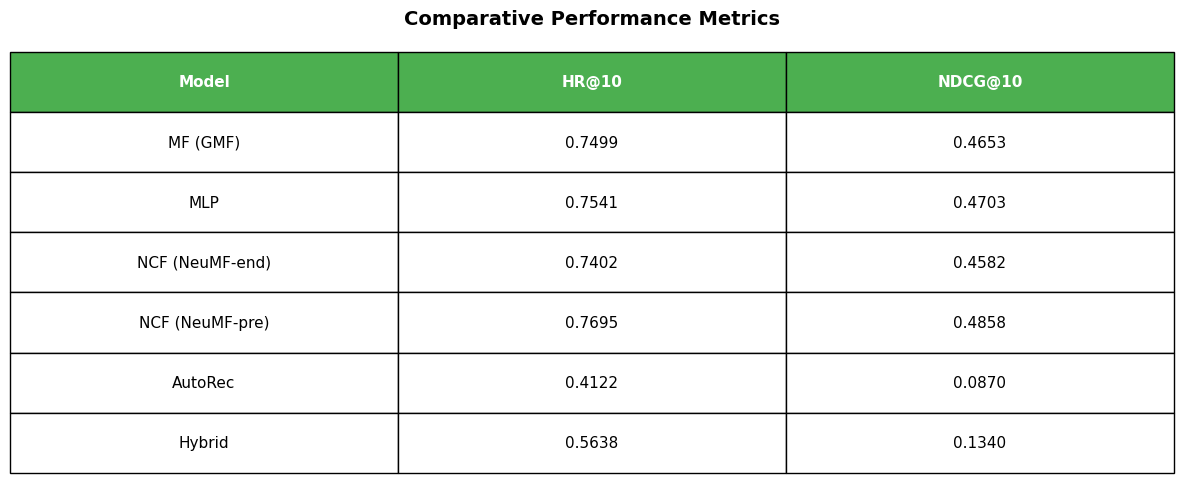

In [21]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['font.size'] = 12

hr_autorec = 0.412228    # Obtained during AutoRec training
ndcg_autorec = 0.087042  # Obtained during AutoRec training

hr_hybrid = 0.5638  # Obtained during hybrid training
ndcg_hybrid = 0.1340   # Obtained during hybrid training


def format_metric(value):
    """Format metric value, handling None and NaN"""
    if value is None:
        return "N/A"
    try:
        if np.isnan(value) or np.isinf(value):
            return "N/A"
        return f"{value:.4f}"
    except (TypeError, ValueError):
        return "N/A"

comparison_data = {
    'Model': ['MF (GMF)', 'MLP', 'NCF (NeuMF-end)', 'NCF (NeuMF-pre)', 'AutoRec', 'Hybrid'],
    'HR@10': [
        format_metric(best_hr_gmf),
        format_metric(best_hr_mlp),
        format_metric(best_hr_neumf_end),
        format_metric(best_hr_neumf_pre),
        format_metric(hr_autorec),
        format_metric(hr_hybrid)
    ],
    'NDCG@10': [
        format_metric(best_ndcg_gmf),
        format_metric(best_ndcg_mlp),
        format_metric(best_ndcg_neumf_end),
        format_metric(best_ndcg_neumf_pre),
        format_metric(ndcg_autorec),
        format_metric(ndcg_hybrid)
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Create visual table
fig_table, ax_table = plt.subplots(figsize=(12, 5))
ax_table.axis('tight')
ax_table.axis('off')
table = ax_table.table(
    cellText=df_comparison.values,
    colLabels=df_comparison.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# Style the table
for i in range(len(df_comparison.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Comparative Performance Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'table_4.1_comparative_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

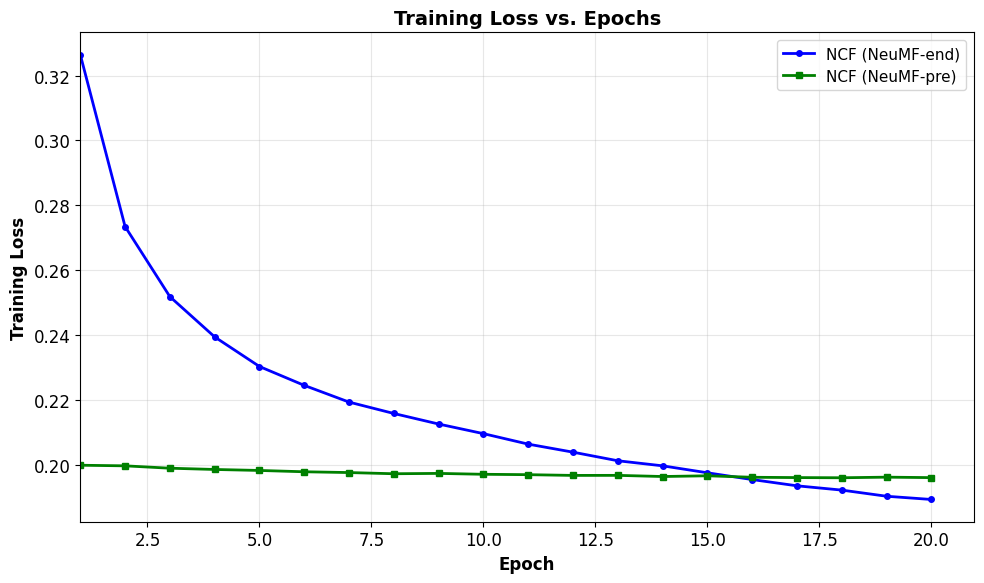

In [22]:

# Get NCF training loss (use NeuMF-end as representative)
ncf_epochs = training_history['epoch']
ncf_losses = training_history['loss']


fig_loss, ax_loss = plt.subplots(figsize=(10, 6))

# Plot NCF (NeuMF-end)
ax_loss.plot(ncf_epochs, ncf_losses, 'b-', linewidth=2, label='NCF (NeuMF-end)', marker='o', markersize=4)

# Plot NCF (NeuMF-pre) if available
if 'neumf_pre_training_history' in locals() and len(neumf_pre_training_history['loss']) > 0:
    ax_loss.plot(
        neumf_pre_training_history['epoch'],
        neumf_pre_training_history['loss'],
        'g-', linewidth=2, label='NCF (NeuMF-pre)', marker='s', markersize=4
    )

ax_loss.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax_loss.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax_loss.set_title('Training Loss vs. Epochs', fontsize=14, fontweight='bold')
ax_loss.legend(loc='best', fontsize=11)
ax_loss.grid(True, alpha=0.3)
ax_loss.set_xlim(left=1)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'figure_4.1_training_loss.png'), dpi=300, bbox_inches='tight')
plt.show()